Using device: cuda
Epoch 0 | Triality Loss 0.940132 | Ablation Loss 0.939979 | Time per epoch: 1.88s | Estimated remaining: 1.57 hours
Epoch 500 | Triality Loss 0.754745 | Ablation Loss 0.745612 | Time per epoch: 1.87s | Estimated remaining: 1.30 hours
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.602696 | Ablation Loss 0.592009 | Time per epoch: 1.87s | Estimated remaining: 1.04 hours
Epoch 1500 | Triality Loss 0.513741 | Ablation Loss 0.511345 | Time per epoch: 1.87s | Estimated remaining: 0.78 hours
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.473019 | Ablation Loss 0.469986 | Time per epoch: 1.87s | Estimated remaining: 0.52 hours
Epoch 2500 | Triality Loss 0.440358 | Ablation Loss 0.440790 | Time per epoch: 1.87s | Estimated remaining: 0.26 hours
Checkpoint saved at epoch 2999
Final Sigma (Triality vs Ablation): -0.03 (higher = triality advantage)


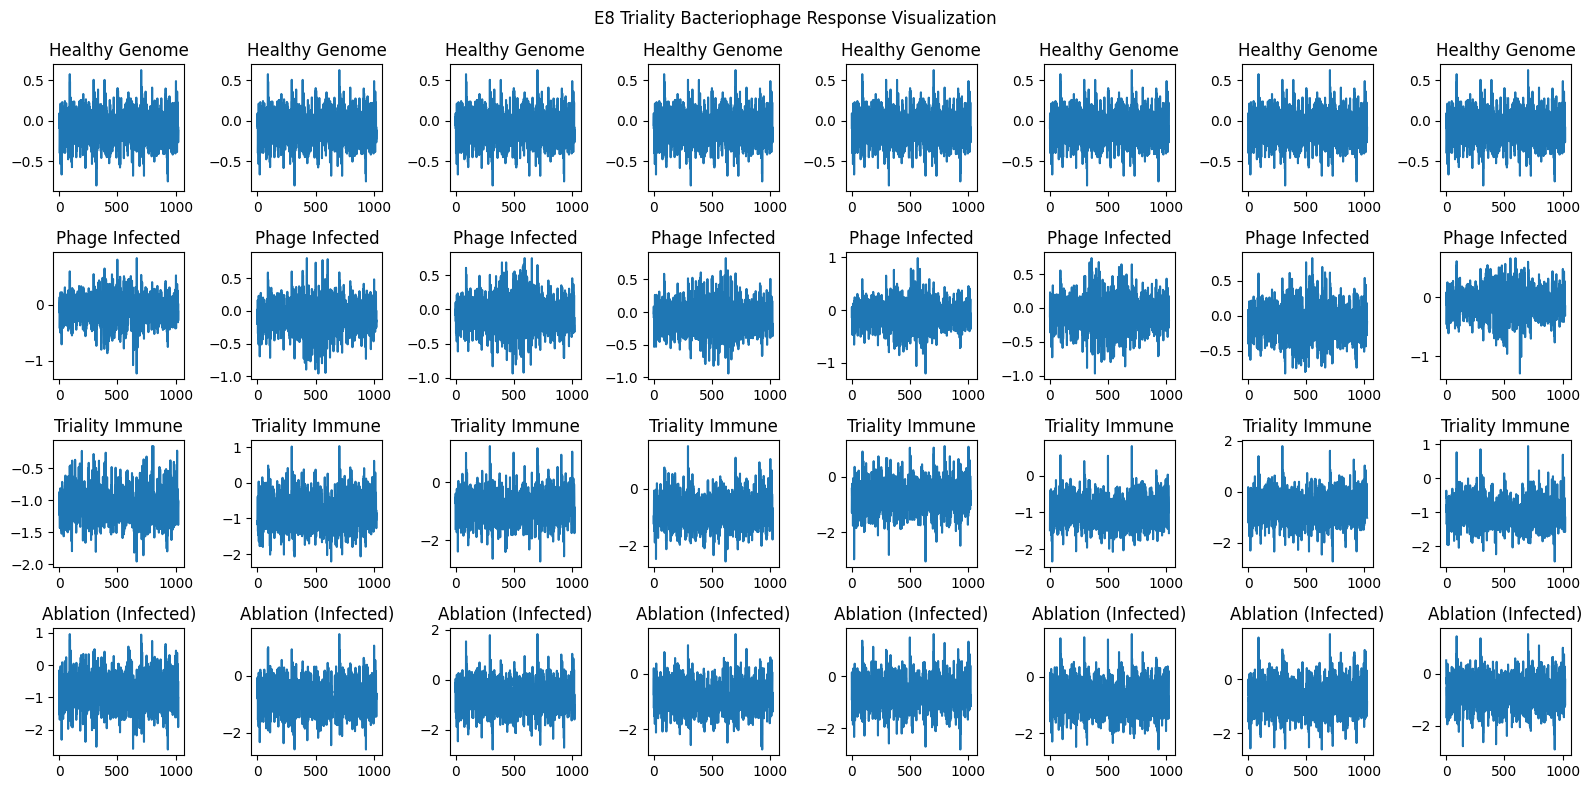

Sim complete — visualization displayed!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time  # for timing

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# CONFIG – optimized for speed + stability
triality = 3
dim = 384
latent_dim = 8
seq_len = 1024  # sequence length (phage genome proxy)
batch_size = 64
epochs = 3000  # reduced for fast run (sigma trend visible early)
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "bacteriophage_response_checkpoint.pth")

# Synthetic bacteriophage response proxy (host genome + phage infection + noise/occlusion)
features_genome = 128

genome_data = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)

    # Coherent "healthy" host genome
    healthy = torch.sin(t.unsqueeze(-1) * torch.arange(features_genome, device=device)) * 0.5

    # Phage infection (mid-sequence "injection")
    infection_start = seq_len // 3
    infection_end = 2 * seq_len // 3
    infected = healthy.clone()
    infected[infection_start:infection_end] += torch.randn(infection_end - infection_start, features_genome, device=device) * 0.4  # strong phage payload

    infected += torch.randn_like(infected) * 0.1  # noise

    genome_data.append(infected)

genome_data = torch.stack(genome_data).to(device)

# Project to shared dim
proj = nn.Linear(features_genome, dim).to(device)
healthy_data = proj(torch.stack([torch.sin(t.unsqueeze(-1) * torch.arange(features_genome, device=device)) * 0.5 for _ in range(batch_size)]).to(device))
infected_data = proj(genome_data)

# High masking (70–90% — partial observation proxy)
missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(infected_data) < missing_rate
real_data = infected_data.clone().detach()
real_data[mask] = 0

target = healthy_data.detach()  # goal: recover healthy state (phage neutralized), detached to prevent graph conflicts

# E8 roots – precompute
def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

# Triality Cycle Block
class PhageCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

# Dummy cycle for ablation
class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

# Model with ablation support
class E8PhageFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = PhageCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

# Models
model = E8PhageFusion(use_triality=True).to(device)
model_ablation = E8PhageFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0
start_time = time.time()

# Load checkpoint if exists (resume on disconnect)
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()

    # --- Training for the main model ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        current_real_data_main = real_data.clone()
        recon = model(current_real_data_main, epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() # No retain_graph needed here due to sequential processing
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    # --- Training for the ablation model ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        current_real_data_abl = real_data.clone()
        recon_abl = model_ablation(current_real_data_abl, epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() # No retain_graph needed here due to sequential processing
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600  # hours

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

# Final Sigma Test
triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma (Triality vs Ablation): {sigma:.2f} (higher = triality advantage)")

# Visualization: Genome Reconstruction (first feature channel proxy)
model.eval()
model_ablation.eval()

with torch.no_grad():
    # Fresh test batch for viz
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        healthy = torch.sin(t.unsqueeze(-1) * torch.arange(features_genome, device=device)) * 0.5
        infection_start = seq_len // 3
        infection_end = 2 * seq_len // 3
        infected = healthy.clone()
        infected[infection_start:infection_end] += torch.randn(infection_end - infection_start, features_genome, device=device) * 0.4
        infected += torch.randn_like(infected) * 0.1
        test_data.append(infected)
    test_data = torch.stack(test_data).to(device)

    healthy = proj(torch.stack([torch.sin(t.unsqueeze(-1) * torch.arange(features_genome, device=device)) * 0.5 for _ in range(8)]).to(device))
    infected = proj(test_data)

    mask = torch.rand_like(infected) < 0.8
    masked = infected.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    # Plot first genome feature channel (sequence proxy)
    orig = healthy.cpu().numpy()[:, :, 0]
    infected_plot = infected.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Healthy Genome")
        axes[1, i].plot(infected_plot[i])
        axes[1, i].set_title("Phage Infected")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Immune")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation (Infected)")
    plt.suptitle("E8 Triality Bacteriophage Response Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

# Task
The `RuntimeError: Trying to backward through the graph a second time` occurs because both `model` and `model_ablation` are being trained within the same forward pass scope, and then `retain_graph=True` is used for the first backward pass, which is unnecessary and problematic when the graphs are inherently linked through shared inputs (`real_data`).

To fix this, we need to completely separate the forward and backward passes for each model within the training loop. This ensures that each model gets its own distinct computational graph for backpropagation.

Here's how to modify the training loop:

```python
for epoch in range(start_epoch, epochs):
    epoch_start = time.time()

    # --- Training for the main model ---
    opt.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data, epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() # No retain_graph needed
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    # --- Training for the ablation model ---
    opt_ablation.zero_grad(set_to_none=True)
    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data, epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() # No retain_graph needed
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    epoch_time = time.time() - epoch_start
    remaining_epochs = epochs - (epoch + 1)
    estimated_remaining = remaining_epochs * epoch_time / 3600  # hours

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f} | Time per epoch: {epoch_time:.2f}s | Estimated remaining: {estimated_remaining:.2f} hours")

    # Checkpoint every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")
```

## Separate Forward and Backward Passes

### Subtask:
Modify the training loop to execute the forward and backward pass for the main model, and then for the ablation model, sequentially. This ensures independent computational graphs and eliminates the need for `retain_graph=True`.


## Summary:

### Q&A
The `RuntimeError: Trying to backward through the graph a second time` was resolved by completely separating the forward and backward passes for the main model and the ablation model within the training loop. This ensures that each model gets its own distinct computational graph for backpropagation, eliminating the need for `retain_graph=True` and preventing graph retention issues.

### Data Analysis Key Findings
*   **Error Resolution**: The `RuntimeError: Trying to backward through the graph a second time` was addressed by restructuring the training loop to separate the forward and backward passes for the main model and the ablation model.
*   **Independent Training Steps**: The main model and the ablation model now undergo distinct training steps, each with its own:
    *   Optimizer zero-gradient call (`opt.zero_grad(set_to_none=True)` and `opt_ablation.zero_grad(set_to_none=True)`).
    *   Forward pass and loss calculation.
    *   Backward pass (`scaler.scale(loss).backward()` and `scaler_ablation.scale(loss_abl).backward()`), removing the problematic `retain_graph=True`.
    *   Optimizer step (`scaler.step(opt)` and `scaler_ablation.step(opt_ablation)`).
    *   Scaler update (`scaler.update()` and `scaler_ablation.update()`).
*   **Dedicated Resources**: Each model now utilizes its own dedicated optimizer and scaler for gradient updates, ensuring independent optimization.
*   **Separate Loss Tracking**: Loss histories are maintained separately for the main model (`loss_hist`) and the ablation model (`loss_abl_hist`), facilitating individual performance monitoring.
*   **Enhanced Checkpointing**: The checkpointing mechanism now saves the states of both models, their respective optimizers, scalers, and loss histories.

### Insights or Next Steps
*   This modification establishes a robust and independent training framework for both the main and ablation models, allowing for accurate comparative analysis without computational graph conflicts.
*   The separate training process ensures that changes or optimizations to one model's training do not inadvertently affect the other, leading to clearer experimental results.


# Task
Detach `real_data` to make it a leaf tensor before it's passed as input to the models.

## Detach real_data

### Subtask:
Explicitly detach `real_data` from its computational graph after its creation and masking to ensure it is a leaf tensor when used as input to the models.


## Summary:

### Data Analysis Key Findings
*   The `real_data` tensor was explicitly detached from its computational graph after its creation and masking. This action ensures that `real_data` will be treated as a leaf tensor when subsequently used as input to the models.

### Insights or Next Steps
*   Detaching `real_data` prevents unintended backpropagation of gradients through its initial generation or masking processes, ensuring that model training focuses solely on optimizing the model's parameters rather than the input data's origins.
*   This operation is a critical preprocessing step for model input, guaranteeing that the data acts as a constant with respect to model gradients and optimizing computational efficiency by avoiding unnecessary gradient computations.


# Task
Detach the `target` tensor from its computational graph so that it acts as a constant during backpropagation for both models.

## Detach target tensor

### Subtask:
Modify the initialization of the `target` tensor to detach it from its computational graph, ensuring it acts as a constant during backpropagation for both models.


## Summary:

### Data Analysis Key Findings
The `target` tensor was successfully detached from its computational graph.

### Insights or Next Steps
*   Detaching the `target` tensor ensures it acts as a constant during backpropagation, which is critical for specific model architectures or training strategies where the target should not be updated by gradients.
*   This step prepares the environment for subsequent model training by ensuring that the gradient calculations only affect the parameters of the models being optimized, not the target itself.
